In [1]:
import os
import requests
headers = {
  "Content-Type": "application/json",
  "api_token": "BRIA_API_TOKEN" # Replace with your Bria API token
}

# Tailored-Generation: 

## LoRA Fine-Tuning Bria's Text-to-Image Model

#### What is LoRA fine-tuning?
LoRA (Low-Rank Adaptation) is a fine-tuning method that enables efficient training of text-to-image models by adjusting only a small set of low-rank matrices rather than modifying the entire model. 

Instead of retraining all the parameters of a large model, LoRA inserts lightweight trainable layers into the architecture and updates only these layers during training. 

This significantly reduces the computational cost and memory requirements while allowing the model to quickly learn new concepts. Because the core model remains unchanged, LoRA makes it easier to deploy and switch between different fine-tuned adaptations without having to maintain multiple large model copies.

#### Fine-Tuning Bria's Foundation Model
For fine-tuning, whether through LoRA or full-fine-tuning, we'll use Bria's latest **4B-Adapt** model, which is designed to provide exceptional fine-tuning capabilities for commercial use.

This model excels in aligning to the tuned style while preserving an remarkably high prompt alignment. 


Bria offers an API suite to train, manage and use fine-tuned models: https://docs.bria.ai/tailored-generation

Bria-4B-Adapt weights can also be fine-tuned on-prem. Training and inference instructions can be found here: https://huggingface.co/briaai/BRIA-4B-Adapat


We want to Fine-Tune Bria-4B-Adapt on the following Bria Elephant Images:

In [ ]:
import os
from PIL import Image
from diffusers.utils import make_image_grid

# show all elephant images from /home/ubuntu/demo_gtc/briaphant
images_dir = "./briaphant"
all_images = {f: Image.open(os.path.join(images_dir, f)) for f in os.listdir(images_dir) if f.endswith('.png')}
make_image_grid(all_images.values(), rows=2,cols=4, resize=256)

We need to configure a few things before we can run the API.
- IP-Type: Type of concept we're training on. In this case, we're training a model on a defined character. All supported types:

    - defined_character
    - character_variants
    - object_variants
    - multi_object_set
    - stylized_scene
    - icons

- IP-Name: Required only for defined_character IP type. The name of the character (1-3 words, e.g., "Lora", "Captain Smith"). 

- IP-Description: Required only for defined_character and object_variants IP types. A short phrase (up to 6 words) describing only the most crucial distinguishing features of your character (e.g., "a female character with purple hair").

- IP-Medium: Illustration / Photography

In [3]:
# project configurations

project_name = "bria_elephant"
ip_type = "defined_character"
ip_name = "BriaPhant"
ip_description = "a purple skinned elephant"
ip_medium = "photography"

- Bria uses Bedrock
- Bria uses Sagemaker for training
- Maybe show prefix generation on style images

We first create a project (which can serve for different trainings of the same use-case) and then create a dataset under this project:

In [4]:
# create project
response = requests.post(
    url="https://engine.prod.bria-api.com/v1/tailored-gen/projects",
    headers=headers,
    json={
        "project_name": project_name,
        "ip_name": ip_name,
        "ip_description": ip_description,
        "ip_medium": ip_medium,
        "ip_type": ip_type
    }
)
assert response.status_code == 201
project_id = int(response.json()["id"])


In [6]:
# create dataset
response = requests.post(
    url="https://engine.prod.bria-api.com/v1/tailored-gen/datasets",
    headers=headers,
    json={
        "name": project_name,
        "project_id": project_id,
    }
)
assert response.status_code == 201
dataset_id = response.json()["id"]
prefix = response.json()['caption_prefix']

When the dataset is created, it contains a prefix defined by the project configs. 

This prefix will be used to generate captions for the images in the dataset and for prompting the fine-tuned model at inference.

In [ ]:
print(f' The set prefix in this dataset is: "{prefix}"')

We now need to upload images to this dataset. We'll iterate over the directory with the elephant images. 

This API endpoint not only uploads images to the datset, but also automatically generates captions that complete the set prefix.
Automatic caption creation is done by calling a VLM through the Amazon Bedrock API.

In [14]:
# upload images to dataset

import base64

for file_name in all_images:
    path_to_file = os.path.join(images_dir, file_name)
    file = open(path_to_file, "rb").read()
    file64 = base64_string = base64.b64encode(file).decode("utf-8")
    response = requests.post(
        url=f"https://engine.prod.bria-api.com/v1/tailored-gen/datasets/{dataset_id}/images",
        headers=headers,
        json={
            "file": file64,
            "image_name": file_name,
        }
    )


Once image upload is complete, we need to change the dataset status to Completed (otherwise training will be blocked):

In [15]:
response = requests.put(
    url=f"https://engine.prod.bria-api.com/v1/tailored-gen/datasets/{dataset_id}",
    headers=headers,
    json={
        "status": 'Completed'
    }
)
assert response.status_code == 200
current_dataset = response.json()

Let's look at a few images and their generated captions:

In [ ]:
from demo_utils import display_images

##### show images and captions
for img_data in current_dataset['images'][:4]:
    img_file = img_data['image_name']
    img_caption = img_data['caption']
    display_images([Image.open(os.path.join(images_dir, img_file))], title=f'{prefix}\n{img_caption}', font_size=12, resize=400)


Now that the dataset is ready, we can create a new model and start training.

Bria's API uses **Amazon SageMaker** to manage and run the training sessions initiated through these calls. 

In [ ]:
# create model
name = project_name
response = requests.post(
    url="https://engine.prod.bria-api.com/v1/tailored-gen/models",
    headers=headers,
    json={
        "dataset_id": dataset_id,
        "name": name,
        "description": "gtc_demo",
        "training_version": "max",
        "training_method": "automatic_training",
    }
)
assert response.status_code == 201
model_id = response.json()["id"]

In [24]:
# start training
response = requests.post(
    url=f"https://engine.prod.bria-api.com/v1/tailored-gen/models/{model_id}/start_training",
    headers=headers
)
assert response.status_code == 200

In [ ]:
print(model_id)

Once Training is complete, use the inference API with the model-id:

In [ ]:
from demo_utils import return_images_from_urls

def tailored_gen(prompt, tailored_model, num_results=3, seed=42):
    
    base_url = f"https://engine.prod.bria-api.com/v1/text-to-image/tailored/{tailored_model}"

    payload = {
        "prompt": prompt, 
        "seed": seed, 
        "num_results": num_results,
        "sync": True, 
    }

    response = requests.post(base_url, json=payload, headers=headers)
    print(response.text)
    responses = response.json().get("result", [{}])
    image_urls = [x.get("urls", [None])[0] for x in responses]

    return return_images_from_urls(image_urls)

prompt = "holding a pink cocktail in its trunk and wearing a small pink party hat"
tailored_model = model_id
elephant_image = tailored_gen(prompt, tailored_model, num_results=1)[0]
elephant_image.save('./api_results/elephant_image.jpg')
display_images([elephant_image], f"prompt: \n{prompt}", font_size=10)    

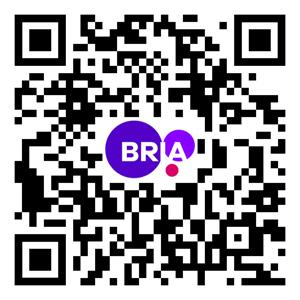

In [18]:
display_images([Image.open("./visuals/qr_code.png")], resize=300)